# From Linear to Deep Classifiers

<img align="right" src="figs/Voosen_2018_Science_Fig.png" width="500">

In this tutorial we design, train & compare 4 different classifiers with different degrees of complexity, to distinguish seismic P-wave seismograms from impulsive noise signals:

- Model 1: linear classifier
- Model 2: simple fully connected neural network
- Model 3: small convolutional neural network
- Model 4: deeper convolutional neural network

The exercise demonstrates how deeper models outperform shallower ones - if we have enough training data. We will also ask the question just how much data is necessary to effectively train a deep classifier. By Men-Andrin Meier, February 15, 2019, mmeier@caltech.edu

<div style="min-height:100px">

##### Motivation

Imagine you run an Earthquake Early Warning (EEW) system, and you want to send out real-time seismic alerts whenever you detect that an earthquake is occuring. Because the seismic waves travel fast (~3km/s for S-waves) EEW is a race against time. If the alerts are to be useful you need to send them out very rapidly. You only have a few seconds to decide whether an observed seismic signal is from a real earthquake or a nuisance signal, e.g. from a nearby truck, or from a cow kicking one of your seismometers... This decision can be difficult because nuisance signals can initially look like earthquake signals. Standard linear classifiers are barely accurate enough for this difficult task, and may cause false and missed alerts. In this tutorial we'll see that with deep learning we can design classifiers that can discriminate between the two signal types almost without errors. (Figure from __[Voosen, 2018, Science](http://science.sciencemag.org/content/362/6414/514/tab-pdf)__)

In [ ]:
import numpy as np
import pylab as plt
import warnings
import os
import h5py
import matplotlib as mpl
%matplotlib inline

import sklearn
from sklearn import linear_model

import pandas as pd
import seaborn as sns

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras import losses
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

### The Waveform Onset Data Set
We will be using a subset of the data set of __[Meier et al., 2019, JGR](https://arxiv.org/abs/1901.03467)__. The data set contains 10,000 short three component seismograms from two signal classes: real earthquake P-waves ("quake") and impulsive noise signals that are not caused by earthquakes  ("noise"). For each record we have the waveforms ('W'), a set of 25 scalar features derived from the waveforms, such as peak amplitudes in different frequency bands ('F'), and class labels ('Y', 1 for quake, 0 for noise). 

##### Training, validation and testing data
We have already split the data set into 8,000 training and 2,000 testing records. During the training process, we will set aside part of the training data as _validation data_, to estimate the out-of-sample prediction error while we optimize the model. Once we have identified a best model, we can then evaluate it on the 2,000 _testing data_ records which were not used anywhere during the training process. For more details on data splits see __[The Elements of statistical learning](https://web.stanford.edu/~hastie/ElemStatLearn/)__, p. 222

##### Feature data
The scalar features contain waveform-derived quantities, such as zero-crossing-rates and peak absolute amplitudes in different frequency bands. They have been measured on each signals with various signal durations. Below we will choose isnp=3 which will extract the features measured over the first 3s since the signal onset. We can also select only a subset of features to analyse, because a lot of them may be correlated.

In [ ]:
# Files
train_file = "../data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5"
val_file   = "../data/onsetWforms_allM3p_180618_rpkd_QN_naug1_Val_nrec10000.h5"

ftrain  = h5py.File(train_file,'r')
W_train = ftrain['/X'][()]        # waveforms
F_train = ftrain['/F'][()]        # scalar features
Y_train = ftrain['/Y'][()]        # labels
ntr     = F_train.shape[0]
nf      = F_train.shape[1]

fval   = h5py.File(val_file,'r')
W_test = fval['/X'][()]
F_test = fval['/F'][()]
Y_test = fval['/Y'][()]
nte    = F_test.shape[0]


# Waveform data parameters
nwin  = 400     # No. of samples per record
ncomp = 3       # No. of record components (Z,E,N)

# Feature data: subselect features to use
#iuse = range(0,nf)     # all
#iuse = range(2,5)      # peak absolute acc., vel., dsp.
iuse = range(18,nf)     # filter bank amplitudes
isnp = 3                 

F_train  = F_train[:,iuse,isnp]
F_test   = F_test[:,iuse,isnp]
nf       = F_train.shape[1]

print("Training feature matrix shape: "+str(F_train.shape))
print("Testing  feature matrix shape: "+str(F_test.shape))

### Data Visualisation
Let's start by visualizing some of the data set so that we know what we are dealing with. 


##### Scalar Waveform Features
As features we are using peak amplitudes in 7 frequency passbands from 0.2-24Hz. After we write the feature data into a _pandas_ dataframe we can use _seaborn_ to easily plot pairs of features against each other. If the features of two classes were linearly separable, a linear classifier would be enough to discriminate between the quake and noise signals with high accuracy. We see, however, that there is a lot of overlap between the two classes, irrespective of which feature pair we are looking at:

In [ ]:
# Write features into pandas data frame
F = F_test.transpose();             
d = {'F1': F[0,:], 'F2': F[1,:], 'F3': F[2,:],'F4': F[3,:],
     'F5': F[4,:], 'F6': F[5,:], 'F7': F[6,:],'class': Y_test}
df = pd.DataFrame(data=d)

sns.pairplot(df, vars=["F1","F2","F3","F4","F5","F6","F7"], hue='class')
plt.show()

##### Waveforms
Let's plot a few randomly chosen example waveforms for either signal class. For most of the quake waveforms we can see a distinct signal onset at 50-150 samples. This is not usually the case for the noise waveforms. But with such short signal durations, it can be difficult to discriminate the two signal classes, even for a human expert seismologist. This shows how difficult this discrimination is in an EEW context.

In [ ]:
nplot = 8    # For each class plot <nplot> examples

# Select random quake examples
idxQ  = np.where(Y_test==1)
idxQ  = idxQ[0]
irndQ = np.random.randint(1,len(idxQ),nplot)
iQ    = idxQ[irndQ]
#print(Y_test[iQ])

# Select random quake examples
idxN  = np.where(Y_test==0)
idxN  = idxN[0]
irndN = np.random.randint(1,len(idxN),nplot)
iN    = idxN[irndN]
#print(Y_test[iN])

fig, axes = plt.subplots(nplot,2);
fig.set_size_inches(12,8);

for iplot in range(1,nplot+1):

    wQ = W_test[iQ[iplot-1],:,1]
    ax = axes[iplot-1,0]
    ax.plot(wQ,color='r')
    ax.yaxis.set_ticks([])
    
    wN = W_test[iN[iplot-1],:,1]
    ax = axes[iplot-1,1]
    ax.plot(wN,color='k')
    ax.yaxis.set_ticks([])

axes[0,0].title.set_text('Quake')
axes[0,1].title.set_text('Noise')
axes[-1,0].set_xlabel('No. of samples')
axes[-1,1].set_xlabel('No. of samples');

### Model 1: A Standard Linear Classifier
As a starting model we fit a standard linear classifier from scikit-learn. The classifier reaches classification accuracies of close to 90%.

In [ ]:
model1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
model1.fit(F_train,Y_train)

train_accurcay = model1.score(F_train,Y_train)
test_accurcay  = model1.score(F_test,Y_test)
print('Accuracy on training data: '+str(train_accurcay)+'%')
print('Accuracy on testing  data: '+str(test_accurcay)+'%')

The feature pairplot shows that the filterbank amplitudes are correlated with each other, i.e. they are not independent. Other feature combinations may form a better basis for the classification exercise. You can vary the feature selection to see if you can increase the accuracy of the linear classifier.

### Model 2: A Small Fully Connected Neural Network
Let's see if we can improve on the linear classifier using a fully connected neural network (FCNN). We use the same feaures as input. 

In keras, building a classifier is easy... you can just stack different layers on top of one another. We use 'dropout' as a form of model regularisation. You can play with the number of nodes per layer and see how the number of free parameters in the model changes.

In [ ]:
model2 = Sequential()
model2.add(Dense(36, input_dim=nf, activation='relu'))  # fully connected layer
model2.add(Dropout(0.2))                                # set n% of weights to zero as a means
                                                        # of regularization
model2.add(Dense(36, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid'))

print(model2.summary())

###### Compile the model and specify 
1. loss function to be used
1. optimization algorithm 
1. performance metrics to keep track of 

(see keras documentation pages for details)

In [ ]:
model2.compile(loss='binary_crossentropy', # 'categorical_hinge', ...
               optimizer='adam',           # 'rmsprop', 'adagrad', ...
               metrics=['accuracy'])       

###### Fit the model to the data
The model parameters are optimized iteratively, using stochastic gradient descent. Instead of processing the entire data set before each parameter update, we use "mini batches", which are small subsets of the total data set. For each mini batch we compute the gradient of the loss function and then update the parameters in the direction of the strongest negative gradient. After setting aside 20% validation data we have 6,400 records for training. With a batch size of 128, this gives 50 batches. A run through all batches is called an "epoch".  

Optimizing the parameters with mini batches allows us to update parameters faster and more efficiently than if the entire data set had to be processed for each update. Furthermore, it will also allow us to do *batch normalization*, which is a form of model regularization (see Model 3). 

In [ ]:
history2 = model2.fit(F_train, Y_train,
                      validation_split=0.2,  # set aside data for model selection
                      epochs=15,             # maximum number of iterations
                      batch_size=128,        # optimise parameters only over small batches
                      verbose = 1)

After training, we can plot the evolution of the classification accuracy and of the loss function across the training epochs:

In [ ]:
def plot_training_history(history):
    ##### Plot model training
    #print(history.history.keys())

    fig = plt.figure()
    fig.set_size_inches(10,5);
    
    # summarize history for accuracy
    ax1=plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()


    # summarize history for loss
    ax2=plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    


In [ ]:
# Plot model evolution during training process
plot_training_history(history2)

### Convolutional Neural Network Classifiers
Standard convolutional neural networks combine a fully connected network with a convolutional _feature extraction system_. In each convolutional layer, the layer inputs are convolved with a series of parallel digital filters ('channels'), each of which is parameterized with a small number of scalar filter coefficients. During the training process, the filter coefficients themselves are optimized (that is, *learned*). This way the network learns directly from the data which aspects (or, features) are important for the task at hand. This frees us from the difficult task of choosing/engineering the right features manually, which is a key advantage of deep learning models.

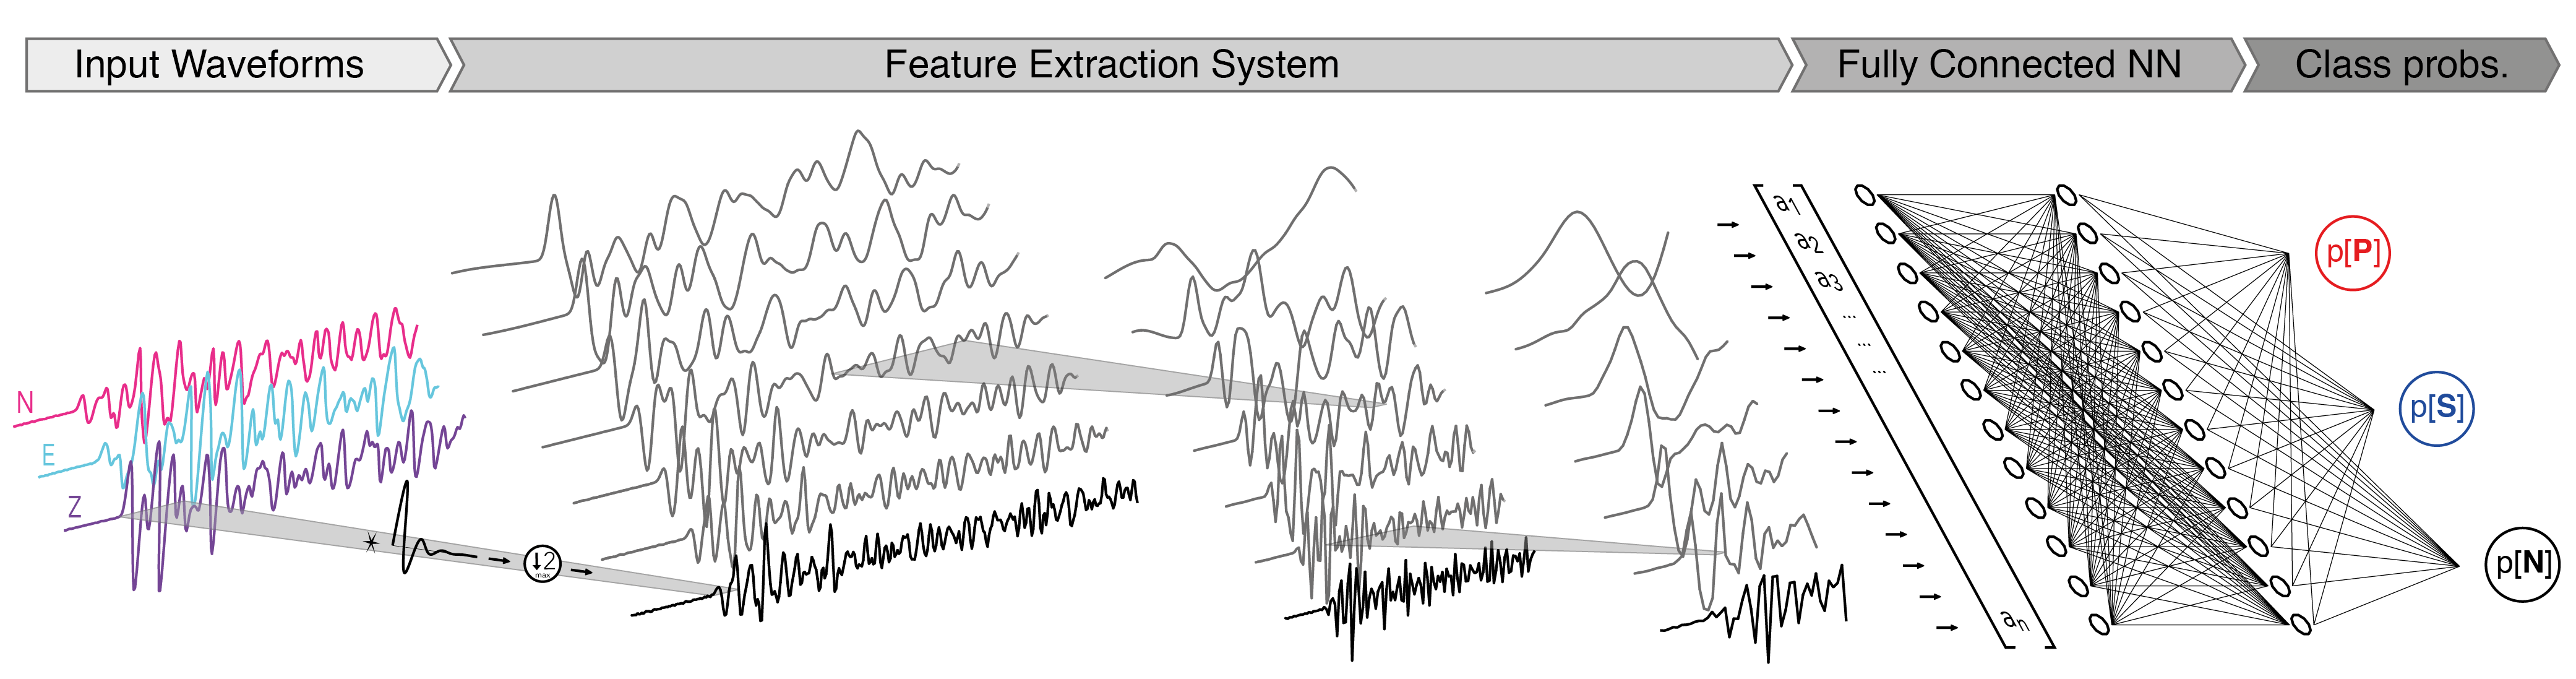


By design the convolutional nodes are only _locally connected_: instead of correlating all waveform samples with each other, as we would in a FCNN, we focus on neighboring samples. This allows the network to make use of temporal (or spatial) structure in the data, and it reduces the number of free parameters in the model. Furthermore, the filter coefficients are 'shared weights' in that the same filter is applied across an entire image; this sharing also reduces the number of parameters.

We also make use of _batch normalisation_: after convolutional and fully connected layers we standardize the output by removing the sample mean of the batch, and then dividing by the sample standard deviation. Since every batch is a little different, this introduces a stochastic element, which makes the trained model insensitive to small and insignificant variations. Batch normalization turns out to be an efficient way to regularise neural network optimisations.

Finally, we use _pooling layers_ after convolutional layers, which downsample the data. This results in a new representation of the input data at a different scale: the more we downsample, the more we coarse graine the data. This allows the neurons to connect across the entire input data array, even though between individual layers they are only locally connected. This practice facilites translation- and scale-invariante object detection.



### Model 3: A tiny convNet classifier
We start with a really small convNet classifier that we can easily train on a laptops. For the first layer we need to specify the dimensions of the raw input data, which is the number of samples per record and the number of components (400,3):  

In [ ]:
model3 = Sequential()
    
#keras.layers.Conv1D(filters, kernel_size, strides=1)
model3.add(Conv1D(4, 8, padding='same', input_shape=(400, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling1D(pool_size=2))

model3.add(Flatten())  # write the output into a single 1D vector

model3.add(Dense(8))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dense(2))
model3.add(Activation('softmax'))

print(model3.summary())

##### One-hot encoding
For the FCNN, the class labels were integers corresponding to the class index (here, 0 for noise, 1 for quake). For convNets, the labels are expected to come in "one-hot encoded" format: a matrix with as many columns as there are classes. On each row (= record), the entry of the true class is 1, all other entries are 0. 

In [ ]:
Y_train_1hot = to_categorical(Y_train)
Y_test_1hot  = to_categorical(Y_test)

##### Compile and train the convNet

In [ ]:
adam = keras.optimizers.adam()

model3.compile(loss=losses.categorical_crossentropy, \
                optimizer=adam, metrics=['accuracy'])

history3 = model3.fit(W_train, Y_train_1hot,
                      validation_split=0.2,
                      batch_size=32, 
                      epochs=20,
                      verbose=2)

##### Training evolution

In [ ]:
plot_training_history(history3)
mpl.rcParams['figure.figsize'] = (4,5)

While for the training data the loss keeps decreasing, the test data loss stabilises. After this, the model "overfits": the improvements it makes are specific to the training data, but it no longer captures any _general_ trend in the data. If the overfitted model is applied to new data it will perform worse than a model from previous training epochs. This issue becomes more important the deeper the network.

<img align="center" src="overfit.png" width="600">








### The Full Monty: a Deep ConvNet Classifier (model4) 
As a final model we use a much deeper convNet classifier that has been used for the same signal/noise discrimination task by __[Meier et al., 2019, JGR](https://arxiv.org/abs/1901.03467)__. This relatively standard convNet model is too large to train on a laptop, so we will be using the pre-trained model that has been optimised over a data set of ~750k seismograms. While the model is much more complex than our Model 3, it would still be considered a small and rather shallow model in a modern data science context. After all, it _only_ has ~235k free parameters... :) As of today (February 2019) the largest published network has [160 billion parameters](https://spectrum.ieee.org/tech-talk/computing/software/biggest-neural-network-ever-pushes-ai-deep-learning)! While this would most certainly make [John von Neumann](https://en.wikiquote.org/wiki/John_von_Neumann) cringe, such extremely complex models perform demonstrably better at the task they have been trained for than simpler models. 

In [ ]:
# Loading and printing the model of Meier et al., 2019, JGR
fullModelName  = '../models/meier_etal_jgr19_b3000.h5'
model4 = keras.models.load_model(fullModelName)
print(model4)
print(model4.summary())
#print(dir(model))

Note how the number of parameters change with increasing depth of the network.  

## Classification Accuracy Across Models
Now that we have trained all models we can apply them to the test data set, which we haven't touched so far. This will allow us to assess the _out of sample model peformance_, i.e. the performance on data that the models have not seen during training. When we compiled the models we told them to keep track of the classification accuracy (`metrics=['accuracy']`). The models will therefore return the accuracies for us to analyse.

In [ ]:
score2 = model2.evaluate(F_test, Y_test)
score3 = model3.evaluate(W_test, Y_test_1hot)
score4 = model4.evaluate(W_test, Y_test_1hot)

# Model 1 is different because it is from scikit-learn, not keras
m1_acc = model1.score(F_test,Y_test)

In [ ]:
# Plot Accuracies
fig = plt.figure()
plt.plot(0,100*m1_acc   ,marker='o',markeredgecolor='k')
plt.plot(1,100*score2[1],marker='o',markeredgecolor='k')
plt.plot(2,100*score3[1],marker='o',markeredgecolor='k')
plt.plot(3,100*score4[1],marker='o',markeredgecolor='k')

plt.ylabel("Classification accuracy [%]")
plt.grid(True)
plt.ylim((85, 100))
plt.xlim((-1, 4))

plt.xticks([0,1,2,3], 
           ('linear classifier', 'feature FCNN', 'mini CNN', 'deeper CNN'),
           rotation=40)
plt.show();


The trend is clear: the more complex, deeper models that work with raw data perform better than the simpler, feature-based ones. The deeper convNet classifier reaches very high accuracy which may be close to the error rate in the data set itself. This is one of the reasons why deep learning models are such a game changer: if we have enough data we can now do classification and regression tasks _much_ better. In fact, for many tasks we can approach the performance of human experts, or even exceed it.  

##### Performance Analysis With Precision & Recall
For each input seismogram the neural network classifiers return a probability estimate that the seismogram belongs to any of the signal classes (here, _p(quake)_ and _p(noise)_). We can then define a _triggering threshold_: when the estimated _p(quake)_ exceeds the triggering threshold we classify it as a quake signal. We can then evalute the model by how many correct classifications it makes. If we take quakes to be 'positive' events we can define 
- true positives: 'TP', quake signal classified as quake
- true negative:  'TN', noise signal classified as noise
- false positive: 'FP', noise signal classified as quake
- false negative: 'FN', noise signal classified as noise

We can then count how often each of these four cases occur, and compute
- Precision: TP/(TP+FP)
- Recall:    TP/(TP+FN)

Precision says: 'Of all the quake detections you've made, how many were correct?'. Recall says: 'Of all the quakes you should have detected, how many _did_ you detect?'. The two quantitites trade off with each other: if we choose a low triggering threshold we have no missed (FN) cases, but many FP cases. If we increase the threshold we reduce the number of FP cases, but now we start to miss some detections. Depending on the context, either precision or recall may be more important, so we can use the triggering threshold as a tuning parameter.

In [ ]:
def get_precall(y_prob,y_test,prPrimeVect):
        
    y_test = y_test.flatten()
    
    pr = []
    re = []
    ac = []

    for p_min in prPrimeVect:
        lgc_predQ = (y_prob>=p_min)
        lgc_testQ = (y_test==1)
        
        ntp       = np.sum( lgc_predQ &  lgc_testQ)
        ntn       = np.sum(~lgc_predQ & ~lgc_testQ)
        nfp       = np.sum( lgc_predQ & ~lgc_testQ)
        nfn       = np.sum(~lgc_predQ &  lgc_testQ)
        precision = np.true_divide(ntp,(ntp+nfp))
        recall    = np.true_divide(ntp,(ntp+nfn))
        accuracy  = np.true_divide((ntp+ntn),(ntp+ntn+nfp+nfn))
        pr.append(precision)
        re.append(recall)
        ac.append(accuracy)
        
    return pr, re, ac

In [ ]:
Y_prob2 = model2.predict_proba(F_test, verbose=1)
Y_prob3 = model3.predict_proba(W_test, verbose=1)
Y_prob4 = model4.predict_proba(W_test, verbose=1)
#print(Y_prob2)

prPrime = np.arange(0, 1.0, 0.1)
npr     = prPrime.shape[0]
pr2, re2, ac2  = get_precall(Y_prob2,Y_test,prPrime)
pr3, re3, ac3  = get_precall(Y_prob3[:,1],Y_test,prPrime)
pr4, re4, ac4  = get_precall(Y_prob4[:,1],Y_test,prPrime)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

p2 = plt.scatter(re2,pr2, c=prPrime, cmap='jet', marker='o', edgecolor='k')
p3 = plt.scatter(re3,pr3, c=prPrime, cmap='jet', marker='v', edgecolor='k')
p4 = plt.scatter(re4,pr4, c=prPrime, cmap='jet', marker='s', edgecolor='k')
#ax.annotate(str(ntl), xy=(re1[-1]-.005, pr1[-1]-.005))                
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.plot([0,2],[1,1],c='k',linewidth=0.5)
plt.plot([1,1],[0,2],c='k',linewidth=0.5)
plt.xlim((0.85, 1.002))
plt.ylim((0.85, 1.002))
plt.legend( (p2,p3,p4), ('Model 2', 'Model 3', 'Model 4'))
cbar = plt.colorbar();
cbar.set_label('Probability threshold');

__Conclusion:__ The more data you have, the deeper a model you can afford, and the better your model performs.

# Just how much data do you need...?
In classical data modelling there is the paradigm that you need more data points than free parameters, ideally at least an order of magnitude more. However, for deep learning models this does not seem to hold. A lot of successful deep learning models actually have orders of magnitude more parameters than data points. Yet, these models demonstrably perform much better than the simpler models on independent testing data sets. 

But there must be a lower limit below which we cannot train a deep model, right? How much data _do_ we need to successfully train a model? The answer is that there is not a binary threshold above which training works, and below which it fails. Instead, the model performance improves continuously the more data is being used. While for shallower models the performance saturates, the performance of deeper models keeps improving as we add more data: 
<img align="center" src="figs/datasize_vs_performance.png" width="400">

The figure above is from __[this excellent blog on deep learning](https://lilianweng.github.io/lil-log/2017/06/21/an-overview-of-deep-learning.html)__  by Lilian Weng.


##### Train two convNets with increasing amounts of data
To quantify these performance tendencies for our particular signal classification problem, we design two additional convNet classifiers, and train them with variable amounts of data. We use the same 2,000 test data records to measure model performance as before.   

In [ ]:
def create_shallowerModel():

    # A relatively shallower model
    model = Sequential()
    
    model.add(Conv1D(6, 8, padding='same', input_shape=(400, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(4, 8, padding='same', input_shape=(400, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())  
    model.add(Dense(12))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss=losses.categorical_crossentropy, \
                optimizer=adam, metrics=['accuracy'])

    return model
    #print(model.summary())

In [ ]:
def create_deeperModel():

    # A relatively deeper model
    model = Sequential()
    
    model.add(Conv1D(16, 16, padding='same', input_shape=(400, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(32, 16, padding='same', input_shape=(400, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())  
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss=losses.categorical_crossentropy, \
                optimizer=adam, metrics=['accuracy'])

    return model
    #print(model.summary())

In [ ]:
def reset_weights(model):

    import keras.backend as K
    
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel_initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias_initializer.run(session=session)    

In [ ]:
nmaxvect = np.logspace(2,4,5,dtype=int)

acc5 = []
acc6 = []

for nmax in nmaxvect:
    print('\nN = '+str(nmax))
    Wi = W_train[0:nmax,:,:]
    Yi = Y_train_1hot[0:nmax,:]
    print(Wi.shape, Yi.shape)
    
    # Shallower model
    model5   = create_shallowerModel()
    nparams5 = model5.count_params()
    print('No of parameters: '+str(nparams5))
    history5 = model5.fit(Wi, Yi,
                      validation_split=0.2, batch_size=32, 
                      epochs=20, verbose=0)

    # Deeper model
    model6   = create_deeperModel()
    nparams6 = model6.count_params()
    print('No of parameters: '+str(nparams6))
    history6 = model6.fit(Wi, Yi,
                      validation_split=0.2, batch_size=32, 
                      epochs=20, verbose=0)

    """
    # Meier et al., 2019, JGR model
    reset_weights(model4)
    nparams6 = model4.count_params()
    print('No of parameters: '+str(nparams6))
    history6 = model4.fit(Wi, Yi,
                      validation_split=0.2, batch_size=32, 
                      epochs=20, verbose=0)
    """

    # Evaluate all models on the same 2,000 test records
    score5 = model5.evaluate(W_test, Y_test_1hot)
    score6 = model6.evaluate(W_test, Y_test_1hot)
    acc5.append(score5[1])
    acc6.append(score6[1])
    print(acc5,acc6)

In [ ]:
fig = plt.figure()
p5 = plt.plot(nmaxvect,acc5,'o',color='r',markeredgecolor='k')
p6 = plt.plot(nmaxvect,acc6,'v',color='b',markeredgecolor='k')
plt.plot(6e5,score4[1]     ,'s',color='y',markeredgecolor='k')
plt.xlabel("No of training data")
plt.ylabel("Classification accuracy")
#plt.title("No of parameters: "+str(nparams))
plt.grid(True)
plt.xscale('log')
plt.legend([p5[0],p6[0]],['Shallower Model ('+str(nparams5)+' params.)', 
                          'Deeper Model ('+str(nparams6)+' params.)'], 
                          loc='lower right')

plt.annotate('Meier et al.,\n2019, JGR',
            xy=(6e5, .99), xytext=(1.5e5, .96),
            #arrowprops=dict(facecolor='black', shrink=0.001,lw=1))                
            arrowprops=dict(arrowstyle="->"))
plt.show();

The model performances continuously improve as we use more training data. Interestingly, the deeper model outperforms the shallower model (and the linear classifier) even if we only have use a few hundred training records.

### Training really deep models
For the sake of simplicity, we have restricted ourselves to models we can train on a laptop. If we want to train really deep models, there is nothing different in principle to how we trained Model 3. The main pratical difference is that we need more data and processing power, preferentially Graphics Processing Units (GPUs), which excel at parallelising the matrix multiplications that lie at the heart of deep learning model optimisations. To fully exploit the speed GPUs can provide you need to define (and train on) _data generators_ that feed data batches to the GPUs in real-time to keep them busy at all times. Here's a __[tutorial](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)__ for how to do this with keras.

I hope you've enjoyed the tutorial. Before we move on to recurrent neural networks and generative models, let's put on our skis and hit the slopes, olé! :) 